In [1]:
import pandas as pd
import numpy as np

In [2]:
delim = ';'

base_path = '/opt/iui-datarelease1-sose2021/'

Xpickle_file = '../X2.pickle'

ypickle_file = '../y2.pickle'

In [3]:
THRESH = 70
LEEWAY = 0
EPOCH = 50

DENSE_COUNT = 2
DENSE_NEURONS = 2400

DENSE2_COUNT = 3
DENSE2_NEURONS = 600

AVG_FROM = 1

In [4]:
def shorten(npList):
    temp        = npList['Force']
    thresh      = THRESH
    leeway      = LEEWAY
    
    temps_over_T = np.where(temp > thresh)[0]
    if len(temps_over_T) > 0:
        return npList[max(temps_over_T[0]-leeway,0):min(len(npList)-1,temps_over_T[-1]+leeway)]
    else:
        return npList

In [5]:
import pickle

def load_pickles():
    _p = open(Xpickle_file, 'rb')
    X = pickle.load(_p)
    _p.close()
        
    _p = open(ypickle_file, 'rb')
    y = pickle.load(_p)
    _p.close()
    
    return (np.asarray(X, dtype=pd.DataFrame), np.asarray(y, dtype=str))

In [6]:
import os

def load_data():
    if os.path.isfile(Xpickle_file) and os.path.isfile(ypickle_file):
        return load_pickles()
    data = []
    label = []
    for user in range(0, user_count):
        user_path = base_path + str(user) + '/split_letters_csv/'
        for file in os.listdir(user_path):
            file_name = user_path + file
            letter = ''.join(filter(lambda x: x.isalpha(), file))[0]
            data.append(pd.read_csv(file_name, delim))
            label.append(letter)
    return (np.asarray(data, dtype=pd.DataFrame), np.asarray(label, dtype=str), np.asarray(file_name))

In [7]:
%%time
X, y = load_data()

X.shape

CPU times: user 5.12 s, sys: 415 ms, total: 5.53 s
Wall time: 5.54 s


(26179,)

In [8]:
%%time
XX = np.array(list(map(shorten, X)), dtype=object)

CPU times: user 6.22 s, sys: 23.5 ms, total: 6.24 s
Wall time: 6.24 s


count    26179.000000
mean        47.987394
std         35.114351
min          2.000000
50%         43.000000
95%         88.000000
96%         94.000000
97%        101.000000
98%        116.000000
99%        150.000000
max       1512.000000
dtype: float64

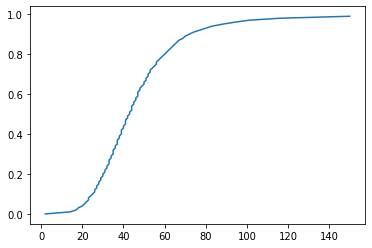

In [9]:
import matplotlib.pyplot as plt

X_len = np.asarray(list(map(len, XX)))
l = []
sq_xlen = pd.Series(X_len)
ptiles = [x*0.01 for x in range(100)]
for i in ptiles:
    l.append(sq_xlen.quantile(i))
plt.plot(l, ptiles)
sq_xlen.describe(percentiles=[x*0.01 for x in range(95,100)])

In [10]:
def plot_data(data):
    fig, axs = plt.subplots(4, 3, figsize=(3*3, 3*4))
    t = data['Millis']
    axs[0][0].plot(t, data['Acc1 X'])
    axs[0][1].plot(t, data['Acc1 Y'])
    axs[0][2].plot(t, data['Acc1 Z'])
    axs[1][0].plot(t, data['Acc2 X'])
    axs[1][1].plot(t, data['Acc2 Y'])
    axs[1][2].plot(t, data['Acc2 Z'])
    axs[2][0].plot(t, data['Gyro X'])
    axs[2][1].plot(t, data['Gyro Y'])
    axs[2][2].plot(t, data['Gyro Z'])
    axs[3][0].plot(t, data['Mag X'])
    axs[3][1].plot(t, data['Mag Y'])
    axs[3][2].plot(t, data['Mag Z'])

    for a in axs:
        for b in a:
            b.plot(t, data['Force'])


In [11]:
threshold_p = 0.99
threshold = int(sq_xlen.quantile(threshold_p))
len_mask = np.where(X_len <= threshold)

X_filter = XX[len_mask]
y_filter = y[len_mask]

X_filter.shape, X_filter[0].shape

((25918,), (52, 15))

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
a = [x.drop(labels='Millis', axis=1) for x in X_filter]

In [13]:
X_filter = pad_sequences(X_filter, dtype=float, padding='post')

In [14]:
def plot_data(data):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data[0])
    axs[0][1].plot(data[1])
    axs[0][2].plot(data[2])
    axs[1][0].plot(data[3])
    axs[1][1].plot(data[4])
    axs[1][2].plot(data[5])
    axs[2][0].plot(data[6])
    axs[2][1].plot(data[7])
    axs[2][2].plot(data[8])
    axs[3][0].plot(data[9])
    axs[3][1].plot(data[10])
    axs[3][2].plot(data[11])
    axs[4][0].plot(data[12])
    axs[4][1].plot(data[13])

#     for a in axs:
#         for b in a:
#             b.plot(t, data['Force'])


(20734, 150, 15)
(5184, 150, 15)
(20734, 52)
(5184, 52)


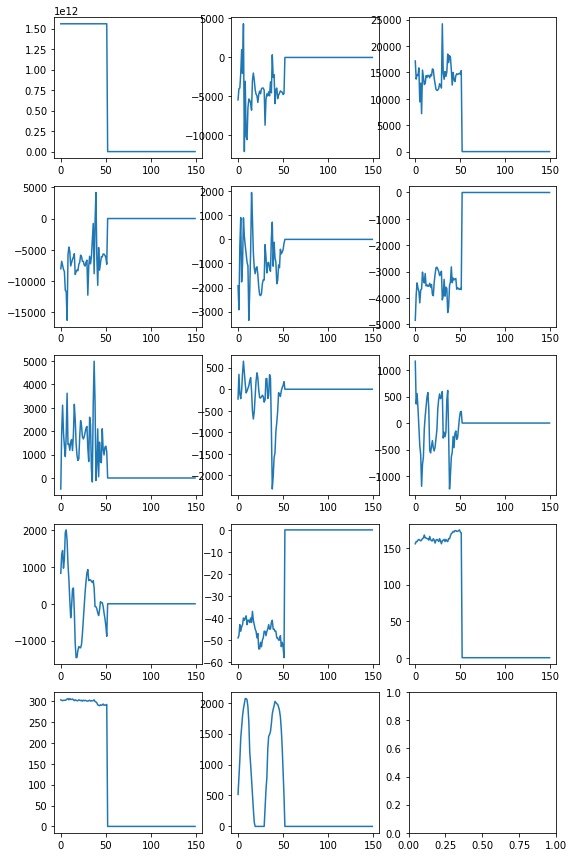

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf

lb = LabelBinarizer()

yt_filter = lb.fit_transform(y_filter)

X_train, X_test, y_train, y_test = train_test_split(X_filter, yt_filter, test_size=0.2, random_state=177013)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plot_data(X_filter[0].T)

fig, axs = plt.subplots(13,2,figsize=(20, 60), sharey=True)
data_count = int(len(X_train)/10)
for i,j in zip(X_train[:data_count], lb.inverse_transform(y_train)[:data_count]):
    num = ord(j) - 64
    f = i.T[13]
    r = int((num-1)/2)%13
    c = (num-1)%2
    axs[r][c].title.set_text(f'{j}')
    axs[r][c].plot(f)
plt.savefig('./all_forces.png')

In [16]:
# FIRST CELL: set these variables to limit GPU usage.
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '1'          # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [17]:
accs = []

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tqdm import tqdm


def build_model():
    model = Sequential()

    model.add(BatchNormalization(input_shape=X_filter[0].shape))
    
    model.add(Flatten())

    for i in range(DENSE_COUNT):
        model.add(Dense(DENSE_NEURONS, activation='relu'))
        
    Dropout(0.2)
    
    for i in range(DENSE2_COUNT):
        model.add(Dense(DENSE2_NEURONS, activation='relu'))
        
    Dropout(0.2)
    
    model.add(Dense(52, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )

    return model
#     model.summary()


In [19]:
for i in tqdm(range(AVG_FROM)):
    model = build_model()
    
    model.fit(X_train, y_train, 
              epochs=EPOCH,
              batch_size=128,
              shuffle=True,
              validation_data=(X_test, y_test),
              verbose=1,
             )
    # Evaluate the model on the test data using `evaluate`
#     print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    print("test loss, test acc:", results)
    accs.append((model,results[1]))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
162/162 [==============================] - 2s 5ms/step - loss: 3.1562 - acc: 0.1829 - val_loss: 2.5782 - val_acc: 0.3098
Epoch 2/50
162/162 [==============================] - 1s 4ms/step - loss: 2.0657 - acc: 0.4226 - val_loss: 1.9569 - val_acc: 0.4579
Epoch 3/50
162/162 [==============================] - 1s 4ms/step - loss: 1.5548 - acc: 0.5398 - val_loss: 1.7179 - val_acc: 0.5149
Epoch 4/50
162/162 [==============================] - 1s 4ms/step - loss: 1.2320 - acc: 0.6281 - val_loss: 1.5439 - val_acc: 0.5484
Epoch 5/50
162/162 [==============================] - 1s 4ms/step - loss: 0.9888 - acc: 0.6937 - val_loss: 1.4862 - val_acc: 0.5700
Epoch 6/50
162/162 [==============================] - 1s 4ms/step - loss: 0.7951 - acc: 0.7524 - val_loss: 1.4870 - val_acc: 0.5689
Epoch 7/50
162/162 [==============================] - 1s 4ms/step - loss: 0.6452 - acc: 0.7965 - val_loss: 1.3981 - val_acc: 0.6030
Epoch 8/50
162/162 [==============================] - 1s 4ms/step - loss: 0.

100%|██████████| 1/1 [00:36<00:00, 36.07s/it]

test loss, test acc: [2.1715357303619385, 0.6375385522842407]


In [20]:
np.mean(np.delete(accs,0,1).astype('float64'))

0.6375385522842407

In [21]:
exit()